In [1]:
'''
Program created to beat CAPTCHAs, allowing our comment spam program to advertise on someone's website.
'''

"\nProgram created to beat CAPTCHAs, allowing our comment spam program to advertise on someone's website.\n"

In [2]:
# Importing the necessary libraries and modules to draw an image
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [3]:
# Defining a function for generating CAPTCHAs
def create_captcha(text, shear=0, size=(100,30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"bretan/Coval-Black.otf", 22)
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    # Apply scale
    shape = image.shape
    shapex, shapey = (int(shape[0] * scale), int(shape[1] * scale))
    image = tf.resize(image, (shapex, shapey))
    return image

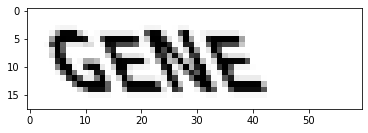

In [4]:
# Generating images
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

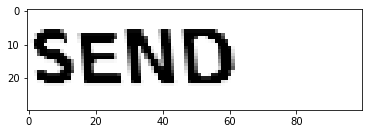

In [5]:
# Another image example with different shear and scale values
image1 = create_captcha("SEND", shear=0.1, scale=1.0)
plt.imshow(image1, cmap='Greys')

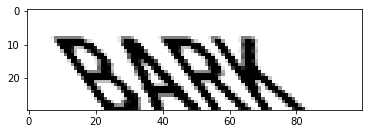

In [6]:
# Another image example with different shear and scale values
image2 = create_captcha("BARK", shear=0.8, scale=1.0)
plt.imshow(image2, cmap='Greys')

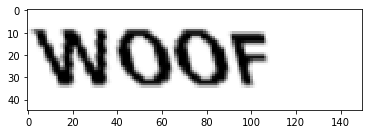

In [7]:
# Another image example with different shear and scale values
image3 = create_captcha("WOOF", shear=0.25, scale=1.5)
plt.imshow(image3, cmap='Greys')

In [8]:
# Defining a function that finds contiguous sections of black pixels in the image and extract them as subimages in order to find the letters
from skimage.measure import label, regionprops

def segment_image(image):
    # Label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # Regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
        if len(subimages) == 0:
            # No subimages found, so return the entire image
            return [image,]
    return subimages

In [9]:
# Getting subimages from first example 'gene' captcha
subimages = segment_image(image)

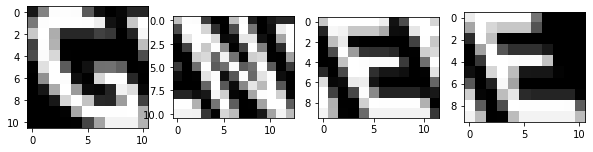

In [10]:
# Checking each of these subimages
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

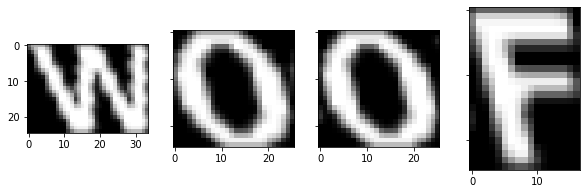

In [11]:
# Getting subimages from 'woof' example captcha and checking each of these subimages
subimages = segment_image(image3)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True)
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

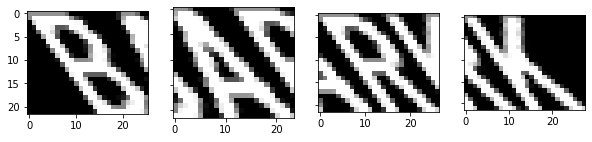

In [12]:
# Getting subimages from 'bark' example captcha and checking each of these subimages
subimages = segment_image(image2)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True)
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [13]:
# Setting random state and an array that holds the options for letters, shear values and scale values
from sklearn.utils import check_random_state

random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.5, 0.05)
scale_values = np.arange(0.5, 1.5, 0.1)

In [14]:
# Defining a function that randomly selects a letter, a shear value and a scale value
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    # We use 30, 30 as the image size to ensure we get all the text in the image
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


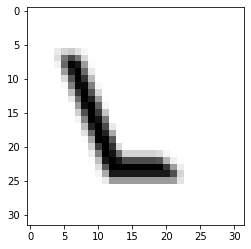

In [15]:
# Calling function to generate a new sample and show it
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print(f'The target for this image is: {letters[target]}')

In [16]:
# Generating dataset
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [17]:
# Performing one-hot-encoding of the targets
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0], 1))

In [18]:
# Turning sparse matrix into a dense NumPy array
y = y.todense()
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))


In [19]:
# Performing train/test split to evaluate the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [20]:
# Checking X_train
print(X_train)

[[1.41720315e-01 4.19931712e-01 4.20314540e-01 ... 2.76758537e-01
  2.72958744e-01 2.17074777e-01]
 [2.92261080e-01 2.34954986e-01 2.34954986e-01 ... 3.55540166e-01
  3.55540166e-01 4.81024931e-01]
 [3.88236922e-03 6.85454392e-02 1.99033975e-01 ... 9.28706714e-02
  9.98880280e-03 2.37274776e-03]
 ...
 [8.05486540e-01 7.58778482e-01 8.13271217e-01 ... 6.32305446e-01
  4.80579879e-01 6.10630365e-01]
 [7.55949340e-02 1.20905462e-01 1.75061946e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.30791917e-01 2.34616657e-01 4.26967178e-01 ... 7.61937384e-04
  1.52387477e-04 4.57162430e-04]]


In [21]:
# Checking X_test
print(X_test)

[[0.         0.         0.01630116 ... 0.25960614 0.26874337 0.22599582]
 [0.29189603 0.30193912 0.33206839 ... 0.         0.         0.        ]
 [0.20347154 0.4151352  0.50503508 ... 0.65378383 0.6697825  0.39070382]
 ...
 [0.15330923 0.15330923 0.30066706 ... 0.83649964 0.56767905 0.56767905]
 [0.59498322 0.61919467 0.6313004  ... 0.87123593 0.83616807 0.76603234]
 [0.         0.         0.01630116 ... 0.25960614 0.26874337 0.22599582]]


In [22]:
# Checking y_train
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# Checking y_test
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [24]:
# Building a neural network using MLPClassifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)

In [25]:
# Getting internal parameters of the neural network
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 14,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [26]:
# Fitting the model
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=14, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [27]:
# Checking weights between each of the layers
clf.coefs_

[array([[-0.07141478,  0.09824427,  0.06802481, ..., -0.09789469,
          0.02155284,  0.00409184],
        [-0.10504656,  0.02625771, -0.10448054, ..., -0.104112  ,
          0.0540388 , -0.17448663],
        [-0.11064233, -0.02084426, -0.0738893 , ...,  0.01535163,
         -0.05178702, -0.02961508],
        ...,
        [-0.14666414, -0.03674435,  0.04530089, ..., -0.03681256,
          0.06771501, -0.04950996],
        [-0.00613282,  0.01548534, -0.12124723, ...,  0.06486444,
          0.05972663, -0.08141555],
        [-0.04478644,  0.02242704,  0.09568235, ...,  0.01049406,
          0.04967368, -0.16332875]]),
 array([[-0.10458644,  0.01971154, -0.14320686, ...,  0.0684006 ,
         -0.29444349, -0.12153226],
        [ 0.00235597, -0.04351238,  0.04927963, ..., -0.05935766,
         -0.03344207,  0.0378321 ],
        [-0.05477724, -0.01843548, -0.08452804, ...,  0.00311091,
          0.14186317,  0.15337322],
        ...,
        [ 0.06918507, -0.06711879, -0.1893313 , ...,  

In [28]:
# Using the trained network to predict the test dataset
y_pred = clf.predict(X_test)

In [29]:
# Evaluating the results
from sklearn.metrics import f1_score
f1_score(y_pred=y_pred, y_true=y_test, average='macro')

0.9560439560439561

In [30]:
# Examining individual class results
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true=y_test))

precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      0.75      0.86         4
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         3
          17       1.00      1.00      1.

In [31]:
# Defining a function to return the predicted word
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    # Perform the same transformations we did for our training data
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
    # Use predict_proba and argmax to get the most likely prediction
    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    # Convert predictions to letters
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

BARK


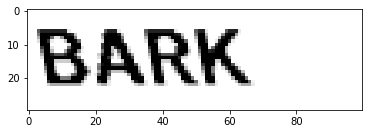

In [32]:
# Testing the function
word = "BARK"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, clf))
plt.imshow(captcha, cmap="Greys")

In [33]:
# Defining a function to perform predictions
def test_prediction(word, net, shear=0.2, scale=1):
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 25, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction


In [34]:
# Using NLTK to create a dataset with a bunch of four-letter English words to test the function
from nltk.corpus import words
valid_words = set([word.upper() for word in words.words() if len(word) == 4])

In [35]:
# Iterating over all words to check how many correct and incorrect predictions we get
num_correct = 0
num_incorrect = 0
for word in valid_words:
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)    # Using random shear
    if correct:
        num_correct += 1
    else: 
        num_incorrect += 1
print(f'Number correct is {num_correct}')
print(f'Number incorrect is {num_incorrect}')


Number correct is 2882
Number incorrect is 2113


In [36]:
accuracy = num_correct / (num_correct+num_incorrect)
print(f'Using shear of {shear:.2f}, the accuracy is: {accuracy}')

Using shear of 0.15, the accuracy is: 0.576976976976977


In [37]:
# Iterating over all words to check how many correct and incorrect predictions we get
num_correct = 0
num_incorrect = 0
for word in valid_words:
    # shear = random_state.choice(shear_values)     We don't need this code as we're setting shear as 0
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=0, scale=scale)    # Using shear = 0
    if correct:
        num_correct += 1
    else: 
        num_incorrect += 1
print(f'Number correct is {num_correct}')
print(f'Number incorrect is {num_incorrect}')

Number correct is 3428
Number incorrect is 1567


In [38]:
accuracy = num_correct / (num_correct+num_incorrect)
print(f'Using shear of 0, the accuracy is: {accuracy}')

Using shear of 0, the accuracy is: 0.6862862862862863


In [39]:
# Defining a function to turn evaluation code dependent on a given shear value
def evaluation_versus_shear(shear_value):
    num_correct = 0
    num_incorrect = 0
    for word in valid_words:
        scale = random_state.choice(scale_values)
        correct, word, prediction = test_prediction(word, clf, shear=shear_value, scale=scale)
        if correct:
            num_correct += 1
        else:
            num_incorrect += 1
    return num_correct / (num_correct+num_incorrect)

In [40]:
# Taking a list of shear values
scores = [evaluation_versus_shear(shear) for shear in shear_values]
print(scores)

[0.6796796796796797, 0.6458458458458458, 0.6592592592592592, 0.6534534534534534, 0.6148148148148148, 0.6008008008008008, 0.5991991991991992, 0.5247247247247248, 0.47427427427427427, 0.3071071071071071]


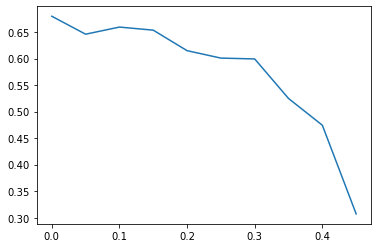

In [41]:
# Plotting the result using matplotlib
plt.plot(shear_values, scores)

In [42]:
# Checking the edit distance between words
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print(f'The number of steps needed is: {steps}')

The number of steps needed is: 1


In [43]:
# Defining a different edit_distance function to check the number of letters in the same positions that are incorrect
def compute_distance(prediction, word):
    len_word = min(len(prediction), len(word))
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

In [44]:
# Defining a improved prediction function
from operator import itemgetter

def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0):
    captcha = create_captcha(word, shear=shear, scale=scale)
    prediction = predict_captcha(captcha, net)
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [45]:
# Testing the code
num_correct = 0
num_incorrect = 0
for word in valid_words:
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print(f'Number correct is {num_correct}')
print(f'Number incorrect is {num_incorrect}')

Number correct is 2960
Number incorrect is 2035


In [46]:
accuracy = num_correct / (num_correct+num_incorrect)
print(f'Using shear of {shear:.2f}, the accuracy is: {accuracy}')

Using shear of 0.05, the accuracy is: 0.5925925925925926
